In [1]:
import numpy as np
from sklearn_ensemble_cv import Ensemble, comp_empirical_ecv, ECV

We make up some fake data for illustration.

In [2]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=300, n_features=100,
                       n_informative=10, n_targets=1,
                       random_state=0, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# The Ensemble class

For users who want to have more control of the ensemble predictor, this section introduces lower-level class and object that we use to implement the cross-validation methods.
For users who just want to use easy interface functions, you can safely skip this section.

We provide `Ensemble` a class for ensemble predictor, whose base class is `sklearn.ensemble.BaggingRegressor`.
This means that the usage of `Ensemble` is basically the same as the latter, except the new class includes several new member functions that we will illustrate below.



## Initialize an object

The initialization of `Ensemble` class is the same as `sklearn.ensemble.BaggingRegressor`, where 

1. The base estimator object, whose hyperparameter `kwargs_regr` is specified when it is initialized. In the following example, we use decision tree as the base estimator. 
2. The hyperparameters for building an ensemble, such as `n_estimators`, `max_samples`, `max_features`, and etc.

In [3]:
from sklearn.tree import DecisionTreeRegressor
kwargs_regr = {'max_depth': 7}
kwargs_ensemble = {'max_samples': 0.8}
regr = Ensemble(estimator=DecisionTreeRegressor(**kwargs_regr), n_estimators=100, **kwargs_ensemble)

After the ensemble object `regr` is initialized, we can fit the data and get the prediction:

In [4]:
regr.fit(X_train, y_train)
regr.predict(X_test)

array([-2.44339626e+00, -1.58755617e+02, -7.68342420e+01, -7.30708502e+01,
       -2.38314940e+00, -5.36167226e+01,  1.82085821e+01, -7.77909144e+01,
       -7.92111129e+00,  1.15613061e+02,  1.94683282e+01, -1.56284002e+02,
        2.22558835e+02, -3.20312243e+00,  1.34901325e+02,  4.80732029e+01,
       -8.84414924e+01, -1.08768674e+02, -6.23830408e+01, -4.83989677e+01,
        1.89889482e+01, -1.03891173e+02,  3.28965137e+00,  1.41903283e+02,
        5.38885464e+01, -8.99560638e-01,  4.17831082e+01, -8.82218573e+01,
        1.58749668e+01, -3.83379434e+01, -6.34455416e+01,  3.84378353e+01,
       -1.28300066e+02,  3.59579655e+00, -5.98329278e+01, -1.35892932e+01,
       -4.05288295e+01,  9.45801920e+01,  1.62601447e+02,  1.34630910e+02,
        1.58863506e+02,  1.29818188e+02,  1.19424706e+01,  6.31017839e+01,
        8.32614353e+01, -1.21121118e+02,  1.52281721e+02,  4.41302063e+01,
       -1.84779060e+02,  1.24246768e+00,  8.52324518e+01, -1.71839211e+02,
        8.99566868e+01,  

## Prediction of individual estimators

We provide a new function `predict_individual` to obtain prediction values from all estimators in the ensemble.
Since we have $n=150$ observations and $M=10$ estimators, the resulting prediction would be of shape $(n,M)=(150,10)$.

In [5]:
Y_train_hat = regr.predict_individual(X_train)
Y_train_hat.shape

(150, 100)

## Compute ECV estimate of the prediction risk

Below, we use function `compute_ecv_estimate` to estimate the prediction risk for various ensemble size $M=1,\ldots,100$, only using the first $M_0=30$ trees.

In [6]:
df_est = regr.compute_ecv_estimate(X_train, y_train, M0=30, return_df=True)
df_est

,M,estimate
0,1,53784.455826
1,2,38754.428458
2,3,33744.419336
3,4,31239.414774
4,5,29736.412038
...,...,...
95,96,24037.526661
96,97,24034.298562
97,98,24031.136343
98,99,24028.038007


We can also compute the test error on the test set using function `compute_risk`. 

In [7]:
df_risk = regr.compute_risk(X_test, y_test, return_df=True)
df_risk

,M,risk
0,1,60742.702465
1,2,42350.281112
2,3,35925.685438
3,4,35401.534556
4,5,32631.182389
...,...,...
95,96,22731.935311
96,97,22666.381807
97,98,22750.284652
98,99,22743.962847


If we plot both the risk estimate and the actual test error, we see a close match.

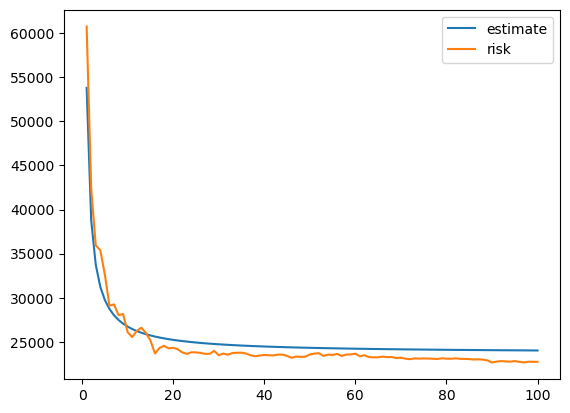

In [8]:
import matplotlib.pyplot as plt
plt.plot(df_est['M'], df_est['estimate'], label='estimate')
plt.plot(df_risk['M'], df_risk['risk'], label='risk')
plt.legend()
plt.show()

Above we show two basic functions and their usage.
One utility of ECV method is that we can also get a risk estimate beyond $M=100$, which gives us a sense how much improvement one can get if we further increase the ensemble size.

In [9]:
df_est = regr.compute_ecv_estimate(X_train, y_train, M_test=1000, M0=30, return_df=True)
df_est

,M,estimate
0,1,53784.455826
1,2,38754.428458
2,3,33744.419336
3,4,31239.414774
4,5,29736.412038
...,...,...
995,996,23754.581868
996,997,23754.551597
997,998,23754.521386
998,999,23754.491235


# ECV estimate for one configuration of ensemble predictors


The function `comp_empirical_ecv` provides an easy way to fit and get risk estimate from ECV.
Similar to the previous section, one need to provide
1. Data: `X_train, y_train`.
2. A regressor class and the parameters to initialize it: `DecisionTreeRegressor, kwargs_regr=kwargs_regr`.
3. The parameters for building the ensemble (with `M` denoting `n_estimators`): `kwargs_ensemble=kwargs_ensemble, M=100`.
4. Extra optional parameters for ECV.

The function returns two objects:
1. An ensemble predictor (an object of `Ensemble`)
2. A np.array or pd.DataFrame object, containing the risk estimates given by ECV.

In [10]:
from sklearn.tree import DecisionTreeRegressor
kwargs_regr = {'max_depth': 7}
kwargs_ensemble = {'max_samples': 0.8}
regr, risk_ecv = comp_empirical_ecv(X_train, y_train, DecisionTreeRegressor, kwargs_regr=kwargs_regr,
                   kwargs_ensemble=kwargs_ensemble, M=100)

One can also pass kwargs `X_val=X_test, Y_val=y_test` to get the actual test errors.

# ECV for tuning hyperparameters

For tuning hyperparameters, such as `max_samples` and `max_features` for the ensemble predictors, and `max_depth` and `min_samples_leaf` for all base predictors, we can make two grids of these two types of tuning hyperparameters respectively.

We recommend using `np.array` for each parameter, and make sure to use the correct dtypes that `sklearn` accept.
If one want to set some hyperparameter to a fix value, simply provide it in the grid as either a scalar or a list/array with length one.

In [11]:
# Hyperparameters for the base regressor
grid_regr = {    
    'max_depth':np.array([6,7], dtype=int), 
    }
# Hyperparameters for the ensemble
grid_ensemble = {
    'max_features':np.array([0.9,1.]),
    'max_samples':np.array([0.6,0.7]),
}

res_ecv, info_ecv = ECV(
    X_train, y_train, DecisionTreeRegressor, grid_regr, grid_ensemble, M=50, M0=25, return_df=True
)

In [12]:
res_ecv

,max_depth,max_features,max_samples,risk_val-1,risk_val-2,risk_val-3,risk_val-4,risk_val-5,risk_val-6,risk_val-7,...,risk_val-42,risk_val-43,risk_val-44,risk_val-45,risk_val-46,risk_val-47,risk_val-48,risk_val-49,risk_val-50,risk_val-51
0,6,0.9,0.6,NaN,83199.456797,60995.366365,53594.002888,49893.321150,47672.912107,46192.639411,...,39874.402297,39848.613574,39824.024326,39800.552772,39778.124398,39756.671170,39736.130846,39716.446369,39697.565339,38791.275934
1,6,0.9,0.7,NaN,78794.144672,57985.216070,51048.906536,47580.751769,45499.858909,44112.597002,...,38191.357156,38167.188830,38144.144612,38122.147859,38101.128739,38081.023494,38061.773792,38043.326160,38025.631493,37176.287468
2,6,1.0,0.6,NaN,56212.614566,38756.845765,32938.256165,30028.961365,28283.384485,27119.666565,...,22152.577882,22132.304050,22112.973188,22094.521001,22076.888911,22060.023434,22043.875637,22028.400664,22013.557324,21301.076964
3,6,1.0,0.7,NaN,55823.732406,38898.358693,33256.567455,30435.671837,28743.134465,27614.776218,...,22798.612966,22778.955157,22760.211665,22742.320149,22725.223812,22708.870794,22693.213649,22678.208885,22663.816560,21972.984980
4,7,0.9,0.6,NaN,87588.687146,64173.929062,56369.009700,52466.550019,50125.074211,48564.090338,...,41901.354298,41874.159457,41848.229492,41823.478162,41799.826892,41777.203937,41755.543661,41734.785897,41714.875388,40759.170977
5,7,0.9,0.7,NaN,80823.126210,58364.087114,50877.740748,47134.567566,44888.663656,43391.394383,...,37000.610900,36974.526070,36949.654487,36925.913431,36903.227533,36881.527978,36860.751809,36840.841313,36821.743491,35905.048018
6,7,1.0,0.6,NaN,56226.235744,39111.179363,33406.160570,30553.651173,28842.145535,27701.141776,...,22831.003782,22811.125667,22792.172117,22774.080091,22756.792155,22740.255869,22724.423254,22709.250332,22694.696712,21996.122983
7,7,1.0,0.7,NaN,55867.448403,39072.240009,33473.837211,30674.635812,28995.114973,27875.434413,...,23096.310074,23076.803444,23058.204099,23040.450179,23023.485322,23007.258067,22991.721334,22976.831965,22962.550325,22277.031615


In [13]:
info_ecv

{'best_params_regr': {'max_depth': 6},
 'best_params_ensemble': {'random_state': 0,
  'n_estimators': 50,
  'max_features': 1.0,
  'max_samples': 0.6},
 'best_n_estimators': 50,
 'best_score': 22013.5573236348,
 'delta': 0.0,
 'M_max': inf,
 'best_n_estimators_extrapolate': inf,
 'best_score_extrapolate': 21301.07696441387}

# SplitCV

In [14]:
from sklearn_ensemble_cv.cross_validation import splitCV
res_splitcv, info_splitcv = splitCV(
        X_train, y_train, DecisionTreeRegressor, grid_regr, grid_ensemble,
        M=50, return_df=True, random_state=0, test_size=0.25,
        )

In [15]:
res_splitcv

,max_depth,max_features,max_samples,risk_val-1,risk_val-2,risk_val-3,risk_val-4,risk_val-5,risk_val-6,risk_val-7,...,risk_val-41,risk_val-42,risk_val-43,risk_val-44,risk_val-45,risk_val-46,risk_val-47,risk_val-48,risk_val-49,risk_val-50
0,6,0.9,0.6,74826.816228,50785.81057,39089.927604,29734.691062,26680.992931,22295.529558,21294.852061,...,18641.161182,18829.662813,18852.036391,18612.581556,18665.020655,18558.422205,18353.7617,18085.037275,18162.78699,18012.339421
1,6,0.9,0.7,74826.816228,50785.81057,39089.927604,29734.691062,26680.992931,22295.529558,21294.852061,...,18641.161182,18829.662813,18852.036391,18612.581556,18665.020655,18558.422205,18353.7617,18085.037275,18162.78699,18012.339421
2,6,1.0,0.6,74826.816228,50785.81057,39089.927604,29734.691062,26680.992931,22295.529558,21294.852061,...,18641.161182,18829.662813,18852.036391,18612.581556,18665.020655,18558.422205,18353.7617,18085.037275,18162.78699,18012.339421
3,6,1.0,0.7,74826.816228,50785.81057,39089.927604,29734.691062,26680.992931,22295.529558,21294.852061,...,18641.161182,18829.662813,18852.036391,18612.581556,18665.020655,18558.422205,18353.7617,18085.037275,18162.78699,18012.339421
4,7,0.9,0.6,74826.816228,50785.81057,39089.927604,29734.691062,26680.992931,22295.529558,21294.852061,...,18641.161182,18829.662813,18852.036391,18612.581556,18665.020655,18558.422205,18353.7617,18085.037275,18162.78699,18012.339421
5,7,0.9,0.7,74826.816228,50785.81057,39089.927604,29734.691062,26680.992931,22295.529558,21294.852061,...,18641.161182,18829.662813,18852.036391,18612.581556,18665.020655,18558.422205,18353.7617,18085.037275,18162.78699,18012.339421
6,7,1.0,0.6,74826.816228,50785.81057,39089.927604,29734.691062,26680.992931,22295.529558,21294.852061,...,18641.161182,18829.662813,18852.036391,18612.581556,18665.020655,18558.422205,18353.7617,18085.037275,18162.78699,18012.339421
7,7,1.0,0.7,74826.816228,50785.81057,39089.927604,29734.691062,26680.992931,22295.529558,21294.852061,...,18641.161182,18829.662813,18852.036391,18612.581556,18665.020655,18558.422205,18353.7617,18085.037275,18162.78699,18012.339421


In [16]:
info_splitcv

{'best_params_regr': {'max_depth': 6},
 'best_params_ensemble': {'random_state': 0,
  'n_estimators': 50,
  'max_features': 0.9,
  'max_samples': 0.6},
 'best_n_estimators': 30,
 'best_score': 17734.030632414982,
 'split_params': {'index_train': array([ 61,  92, 112,   2, 141,  43,  10,  60, 116, 144, 119, 108,  69,
         135,  56,  80, 123, 133, 106, 146,  50, 147,  85,  30, 101,  94,
          64,  89,  91, 125,  48,  13, 111,  95,  20,  15,  52,   3, 149,
          98,   6,  68, 109,  96,  12, 102, 120, 104, 128,  46,  11, 110,
         124,  41, 148,   1, 113, 139,  42,   4, 129,  17,  38,   5,  53,
         143, 105,   0,  34,  28,  55,  75,  35,  23,  74,  31, 118,  57,
         131,  65,  32, 138,  14, 122,  19,  29, 130,  49, 136,  99,  82,
          79, 115, 145,  72,  77,  25,  81, 140, 142,  39,  58,  88,  70,
          87,  36,  21,   9, 103,  67, 117,  47]),
  'index_val': array([114,  62,  33, 107,   7, 100,  40,  86,  76,  71, 134,  51,  73,
          54,  63,  37,  7

# KFoldCV

In [17]:
from sklearn_ensemble_cv.cross_validation import KFoldCV
res_kfoldcv, info_kfoldcv = KFoldCV(
        X_train, y_train, DecisionTreeRegressor, grid_regr, grid_ensemble,
        M=50, return_df=True, shuffle=True, random_state=0, n_splits=2,
        )

In [18]:
res_kfoldcv

,max_depth,max_features,max_samples,risk_val-1,risk_val-2,risk_val-3,risk_val-4,risk_val-5,risk_val-6,risk_val-7,...,risk_val-41,risk_val-42,risk_val-43,risk_val-44,risk_val-45,risk_val-46,risk_val-47,risk_val-48,risk_val-49,risk_val-50
0,6,0.9,0.6,59661.579115,45982.032418,42078.365665,41108.839586,40408.116195,38462.44217,38438.919349,...,27505.025657,27679.491352,27589.714723,27674.163419,27493.660307,27562.891157,27642.973914,27676.799046,27580.691359,27766.357129
1,6,0.9,0.7,59661.579115,45982.032418,42078.365665,41108.839586,40408.116195,38462.44217,38438.919349,...,27505.025657,27679.491352,27589.714723,27674.163419,27493.660307,27562.891157,27642.973914,27676.799046,27580.691359,27766.357129
2,6,1.0,0.6,59661.579115,45982.032418,42078.365665,41108.839586,40408.116195,38462.44217,38438.919349,...,27505.025657,27679.491352,27589.714723,27674.163419,27493.660307,27562.891157,27642.973914,27676.799046,27580.691359,27766.357129
3,6,1.0,0.7,59661.579115,45982.032418,42078.365665,41108.839586,40408.116195,38462.44217,38438.919349,...,27505.025657,27679.491352,27589.714723,27674.163419,27493.660307,27562.891157,27642.973914,27676.799046,27580.691359,27766.357129
4,7,0.9,0.6,59661.579115,45982.032418,42078.365665,41108.839586,40408.116195,38462.44217,38438.919349,...,27505.025657,27679.491352,27589.714723,27674.163419,27493.660307,27562.891157,27642.973914,27676.799046,27580.691359,27766.357129
5,7,0.9,0.7,59661.579115,45982.032418,42078.365665,41108.839586,40408.116195,38462.44217,38438.919349,...,27505.025657,27679.491352,27589.714723,27674.163419,27493.660307,27562.891157,27642.973914,27676.799046,27580.691359,27766.357129
6,7,1.0,0.6,59661.579115,45982.032418,42078.365665,41108.839586,40408.116195,38462.44217,38438.919349,...,27505.025657,27679.491352,27589.714723,27674.163419,27493.660307,27562.891157,27642.973914,27676.799046,27580.691359,27766.357129
7,7,1.0,0.7,59661.579115,45982.032418,42078.365665,41108.839586,40408.116195,38462.44217,38438.919349,...,27505.025657,27679.491352,27589.714723,27674.163419,27493.660307,27562.891157,27642.973914,27676.799046,27580.691359,27766.357129


In [19]:
info_kfoldcv

{'best_params_regr': {'max_depth': 6},
 'best_params_ensemble': {'random_state': 0,
  'n_estimators': 50,
  'max_features': 0.9,
  'max_samples': 0.6},
 'best_n_estimators': 40,
 'best_score': 27452.098338242788,
 'val_score': array([[[59587.01870786, 59736.13952128],
         [44319.79822076, 47644.2666152 ],
         [42347.50804925, 41809.22328144],
         [41204.74298225, 41012.93618921],
         [42651.65194701, 38164.58044364],
         [37833.28895516, 39091.59538434],
         [38299.46455359, 38578.3741436 ],
         [35688.37888013, 36837.6575401 ],
         [34215.84971511, 36358.62196152],
         [32331.21797837, 31829.26196114],
         [31641.77867951, 31716.96971342],
         [31775.15931517, 32137.02912711],
         [30771.12070029, 30441.59175246],
         [30558.966373  , 28472.85959193],
         [30723.29683752, 29167.29264021],
         [31895.08636888, 29485.29783396],
         [31623.5479218 , 29708.88054027],
         [30587.46350967, 28948.13728151],
